In [1]:
import tensorflow as tf
from tensorflow import keras


In [2]:
SEED_NUM=1234
tf.random.set_seed(SEED_NUM)

# Load Data

In [3]:
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences


DATA_IN_PATH = './data_in/'
DATA_OUT_PATH='./data_out/'
TRAIN_INPUT_DATA='train_input.npy'
TRAIN_LABEL_DATA='train_label.npy'
DATA_CONFIGS = 'data_config.json'

train_input = np.load(open(DATA_IN_PATH+TRAIN_INPUT_DATA,'rb'))
train_label = np.load(open(DATA_IN_PATH+TRAIN_LABEL_DATA,'rb'))
prepro_configs = json.load(open(DATA_IN_PATH+DATA_CONFIGS,'r'))

In [4]:
model_name = 'rnn_classifier_en'
BATCH_SIZE =  128
NUM_EPOCHS = 5
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {
    'model_name' : model_name,
    'vocab_size' : prepro_configs['vocab_size'],
    'embedding_dimension':100,
    'dropout_rate':0.2,
    'lstm_dimension':150,
    'dense_dimension':150,
    'output_dimension':1
}

In [5]:
class RNNClassifier(tf.keras.Model):
    def __init__(self,**kargs):
        super(RNNClassifier,self).__init__(name=kargs['model_name'])
        self.embedding = tf.keras.layers.Embedding(input_dim=kargs['vocab_size'],output_dim=kargs['embedding_dimension'])
        
        self.lstm_1_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'],return_sequences=True)
        
        self.lstm_2_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'])
        
        self.dropout = tf.keras.layers.Dropout(kargs['dropout_rate'])
        
        self.fc1 = tf.keras.layers.Dense(units=kargs['dense_dimension'],activation=tf.keras.activations.tanh)
        
        self.fc2 =tf.keras.layers.Dense(units=kargs['output_dimension'],activation=tf.keras.activations.sigmoid)
        
    def call(self,x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.lstm_1_layer(x)
        x = self.lstm_2_layer(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
    

In [6]:
model = RNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
             )

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

earlystop_callback = EarlyStopping(monitor='val_accuracy',min_delta=0.001,patience=1)
checkpoint_path = DATA_OUT_PATH + model_name+'/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir,exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))


cp_callback = ModelCheckpoint(
    checkpoint_path,monitor='val_accuracy',verbose=1,save_best_only=True,save_weights_only=True
)



./data_out/rnn_classifier_en -- Folder already exists 



In [8]:
history = model.fit(
    train_input,
    train_label, 
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_split=VALID_SPLIT,
    callbacks=[earlystop_callback,cp_callback]
)

Epoch 1/5
176/176 [==============================] - 51s 262ms/step - loss: 0.6932 - accuracy: 0.5033 - val_loss: 0.6929 - val_accuracy: 0.5096

Epoch 00001: val_accuracy improved from -inf to 0.50960, saving model to ./data_out/rnn_classifier_en\weights.h5
Epoch 2/5
176/176 [==============================] - 44s 250ms/step - loss: 0.6915 - accuracy: 0.5177 - val_loss: 0.4860 - val_accuracy: 0.7576

Epoch 00002: val_accuracy improved from 0.50960 to 0.75760, saving model to ./data_out/rnn_classifier_en\weights.h5
Epoch 3/5
176/176 [==============================] - 46s 263ms/step - loss: 0.3949 - accuracy: 0.8297 - val_loss: 0.2773 - val_accuracy: 0.8844

Epoch 00003: val_accuracy improved from 0.75760 to 0.88440, saving model to ./data_out/rnn_classifier_en\weights.h5
Epoch 4/5
176/176 [==============================] - 45s 256ms/step - loss: 0.1899 - accuracy: 0.9298 - val_loss: 0.2784 - val_accuracy: 0.8888

Epoch 00004: val_accuracy improved from 0.88440 to 0.88880, saving model to

In [9]:
import matplotlib.pyplot as plt

import os
import json

from tqdm import tqdm
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

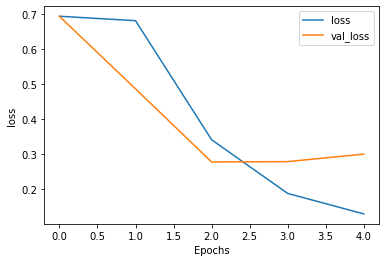

In [10]:
plot_graphs(history,'loss')

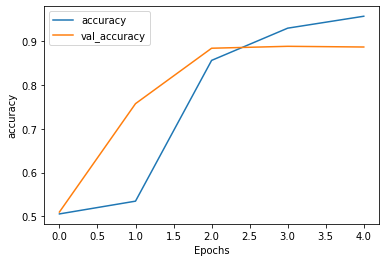

In [11]:
plot_graphs(history,'accuracy')

# Prediction

In [12]:
DATA_OUT_PATH = './data_out/'
TEST_INPUT_DATA = 'test_input.npy'
TEST_ID_DATA = 'test_id.npy'
SAVE_FILE_NM = 'weights.h5'

test_input = np.load(open(DATA_IN_PATH+TEST_INPUT_DATA,'rb'))
test_input = pad_sequences(test_input,maxlen=test_input.shape[1])

# 가장 val_accuracy 가 놓은 weight 로드하기
model.load_weights(os.path.join(DATA_OUT_PATH,model_name,SAVE_FILE_NM))

In [13]:
test_input[93]

array([    1,     6,  2862,   292,    61,  7851,   199,   516,   345,
        2379,    20,     7,  1289,  7851,   104,   475,   217,   120,
        3217,  1236,  3323,  1512,     7,  3149,   231,    22,     1,
           4,  7125,  1941,  7373,   307, 29833,  9301,   118,    92,
           8,    41,     8,    85,  1496, 10719,    92,     8,    41,
          85, 11527, 22041,  9476,     4, 10719,    41,    70,    85,
         835,   179,   302,  1139,  3381,  1671,   278,  4900,  3947,
           9,     4,  7125,  1423,  2592,  7597,  6835,   756, 60061,
         643,     4,    24,    13,   441,     1,  6664,   541,   203,
           1,    10,   810,  1914,    43,    39, 11299,  2387,  9070,
         510,   369,  2791,  8969,  2387,   203,    50,    18,  2592,
        7851, 13944,    88, 13243,   203,  5395,    77,  2463,  2009,
        7998,  5563,  3070,  5564,  1598, 24471,   589,  1941, 15723,
          67,  3063,    27,  3184,  1109,   102,   217,   232,   110,
        7216,  3316,

In [14]:
#예측하기
predictions = model.predict(test_input, batch_size=BATCH_SIZE)

#차원 조절
predictions = predictions.squeeze(-1)



In [16]:
import pandas as pd
test_id = np.load(open(DATA_IN_PATH+TEST_ID_DATA,'rb'),allow_pickle=True)

output = pd.DataFrame(data={"id":list(test_id),"sentiment":list(predictions)})
output.to_csv(DATA_OUT_PATH+'movie_review_result_rnn.csv',index=False,quoting=3)